In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

2024-05-23 13:39:50.961160: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print(f"GPU is available: {tf.test.gpu_device_name()}")
else:
    print("GPU not available, using CPU instead.")


GPU not available, using CPU instead.


In [45]:
# Hyperparameters
epochs = 15
batch_size = 16
batch_size_train = 16
batch_size_test = 16
device = 'cpu'
lr = 1e-3

In [4]:
# Data exploration and preprocessing

# Load dataset and transform images to tensors
dataset = datasets.ImageFolder(root="Covid19-dataset/train", transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables for calculating mean and standard deviation
sum_channels = 0
sum_channels_squared = 0
total_pixels = 0

# Iterate through the dataset to gather pixel statistics
for images, _ in data_loader:
    sum_channels += torch.sum(images, dim=[0, 2, 3])  # Sum up pixel values across all dimensions
    sum_channels_squared += torch.sum(images ** 2, dim=[0, 2, 3])  # Sum of squared pixel values
    total_pixels += images.size(0) * images.size(2) * images.size(3)  # Calculate total number of pixels

# Calculate mean and standard deviation
mean = sum_channels / total_pixels
std_dev = torch.sqrt((sum_channels_squared / total_pixels) - (mean ** 2))

print("Mean:", mean)
print("Standard Deviation:", std_dev)

# we calculate it to transform / normalize the images


mean: tensor([0.5008, 0.5008, 0.5009])
std dev: tensor([0.2861, 0.2861, 0.2861])


In [6]:
# Setting up the transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5008, 0.5008, 0.5009], std=[0.2861, 0.2861, 0.2861])
])

#test the transformation

train_folder = "Covid19-dataset/train"

# list of image file paths in the train folder
image_paths = []
for root, dirs, files in os.walk(train_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):  
            image_paths.append(os.path.join(root, file))

# images were found or not
if not image_paths:
    raise ValueError("No images found in the specified folder.")

# first image path 
first_image_path = image_paths[0]
print("image path:", first_image_path)

# Open the image 
example_image = Image.open(first_image_path)

# Apply the transformations 
transformed_image = image_transforms(example_image)

# Check the type and shape of the transformed image
print(type(transformed_image)) 
print(transformed_image.shape)  

image path: Covid19-dataset/train/Viral Pneumonia/06.jpeg
<class 'torch.Tensor'>
torch.Size([3, 299, 299])


Training size: 200
Validation size: 51
Test size: 66


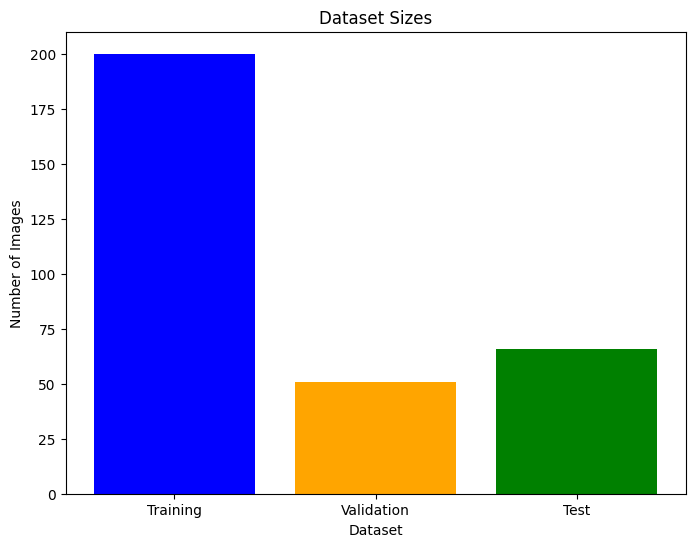

In [14]:
# Load the dataset 
dataset = datasets.ImageFolder(root="Covid19-dataset/train", transform=image_transforms)

# Split the dataset into training and validation sets
train_length = int(0.8 * len(dataset))
val_length = len(dataset) - train_length
train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='Covid19-dataset/test', transform=image_transforms)

# Create DataLoader objects for training, validation, and test datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Print the sizes of each dataset
print(f'Training size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

dataset_sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
dataset_labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(8, 6))
plt.bar(dataset_labels, dataset_sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


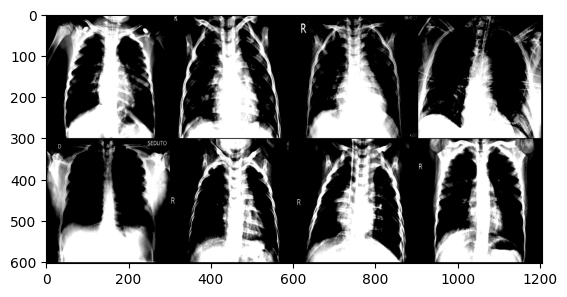

In [70]:
images, labels = next(iter(train_loader))
grid = make_grid(images[:8], nrow=4)
plt.imshow(grid.permute(1, 2, 0))

In [15]:
def get_class_distribution(dataset):
    # Extract labels from the dataset
    labels = []
    for index in dataset.indices:
        label = dataset.dataset.targets[index]
        labels.append(label)
    labels = np.array(labels)
    
    # Count occurrences of each label
    class_counts = np.bincount(labels, minlength=len(dataset.dataset.classes))
    
    return class_counts


In [22]:
train_distribution = get_class_distribution(train_dataset)
val_distribution = get_class_distribution(val_dataset)
test_distribution = np.bincount(test_dataset.targets, minlength=len(test_dataset.classes))

# Define class labels
class_labels = dataset.classes

# Print class labels and their distributions for training dataset
print("Training Dataset:")
for label, count in zip(class_labels, train_distribution):
    print(f"Class: {label}, Count: {count}")

# Print class labels and their distributions for validation dataset
print("\nValidation Dataset:")
for label, count in zip(class_labels, val_distribution):
    print(f"Class: {label}, Count: {count}")

# Print class labels and their distributions for test dataset
print("\nTest Dataset:")
for label, count in zip(class_labels, test_distribution):
    print(f"Class: {label}, Count: {count}")

for images, labels in train_loader:
    print(labels)        
    break

Training Dataset:
Class: Covid, Count: 85
Class: Normal, Count: 59
Class: Viral Pneumonia, Count: 56

Validation Dataset:
Class: Covid, Count: 26
Class: Normal, Count: 11
Class: Viral Pneumonia, Count: 14

Test Dataset:
Class: Covid, Count: 26
Class: Normal, Count: 20
Class: Viral Pneumonia, Count: 20
tensor([0, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2])


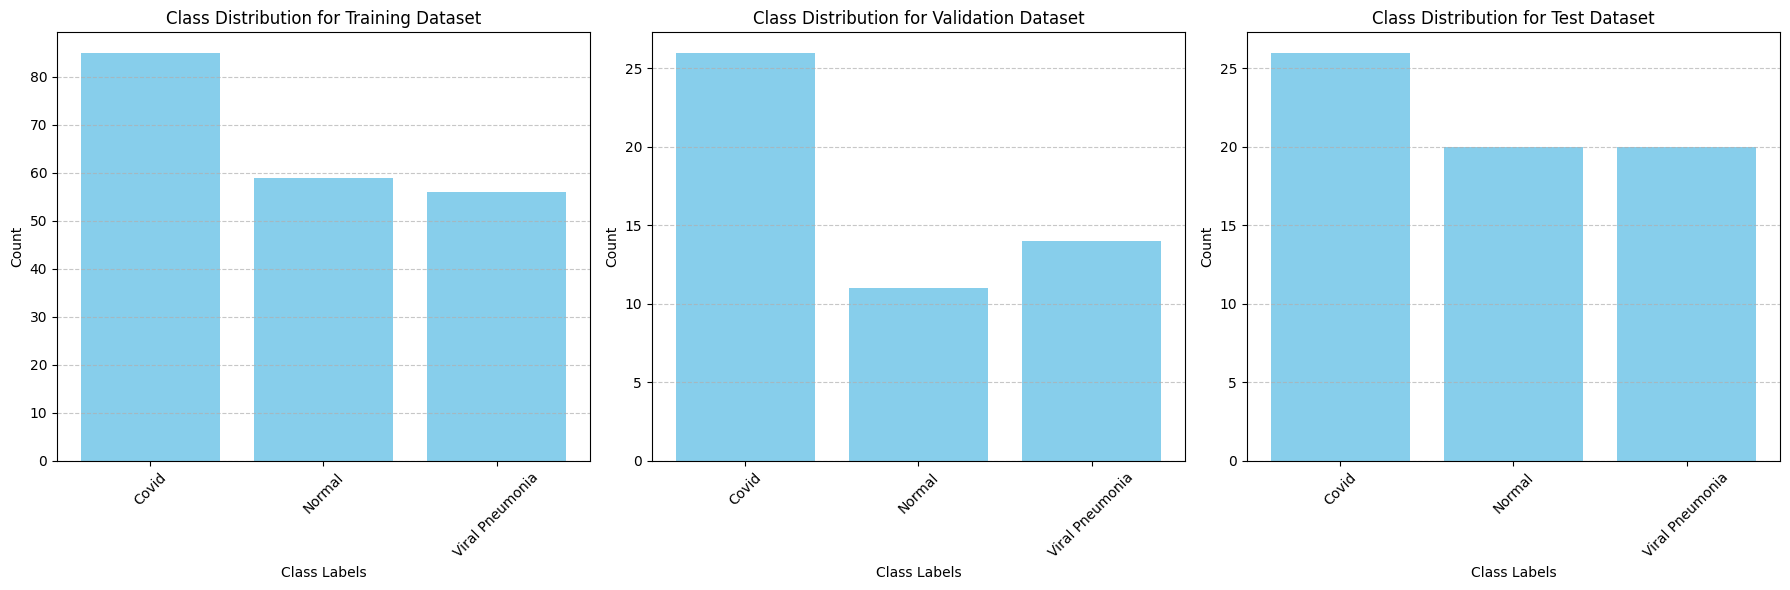

In [26]:
def plot_class_distribution(ax, class_labels, class_counts, dataset_name):
    ax.bar(class_labels, class_counts, color='skyblue')
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Count')
    ax.set_title(f'Class Distribution for {dataset_name} Dataset')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create subplots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot class distributions for training dataset
plot_class_distribution(axes[0], class_labels, train_distribution, 'Training')

# Plot class distributions for validation dataset
plot_class_distribution(axes[1], class_labels, val_distribution, 'Validation')

# Plot class distributions for test dataset
plot_class_distribution(axes[2], class_labels, test_distribution, 'Test')

# Adjust layout
plt.tight_layout()
plt.show()

In [38]:
class MyConvNet(nn.Module):
    def __init__(self, input_size):
        super(MyConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Calculate the input size for the first linear layer
        self.fc_input_size = self.calculate_fc_input_size(input_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def calculate_fc_input_size(self, input_size):
        dummy_input = torch.randn(1, *input_size)
        with torch.no_grad():
            features_output = self.features(dummy_input)
        return features_output.view(1, -1).size(1)


In [51]:
# Training

input_size = (3, 299, 299)
model = MyConvNet(input_size).to(device)

training_writer = SummaryWriter(log_dir=f"logs/cnn_lr_{lr}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
best_val_loss = float('inf')
accumulation_steps = 4  

# Training loop
best_val_loss = float('inf')
for epoch in range(epochs):
    print(f'Epoch: {epoch+1} / {epochs}')
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        model.train()
        output = model(images)
        loss = criterion(output, labels)
        loss = loss / accumulation_steps  
        loss.backward()

        if (batch + 1) % accumulation_steps == 0 or batch == len(train_loader) - 1:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps  

        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * (correct_train / total_train)
    
    print(f'Training loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f}')

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for batch, (val_images, val_labels) in enumerate(val_loader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            output = model(val_images)
            loss = criterion(output, val_labels)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * (correct_val / total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "cnn_model.pth")

    training_writer.add_scalar("Train loss", train_loss, epoch)
    training_writer.add_scalar("Train accuracy", train_accuracy, epoch)
    training_writer.add_scalar("Validation loss", val_loss, epoch)
    training_writer.add_scalar("Validation accuracy", val_accuracy, epoch)

    print(f'Validation loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

Epoch: 1 / 15
Training loss: 1.8720 | Train accuracy: 43.5000
Validation loss: 1.6094 | Validation Accuracy: 21.5686
Epoch: 2 / 15
Training loss: 0.8583 | Train accuracy: 62.0000
Validation loss: 0.3897 | Validation Accuracy: 74.5098
Epoch: 3 / 15
Training loss: 0.5095 | Train accuracy: 78.0000
Validation loss: 0.3893 | Validation Accuracy: 78.4314
Epoch: 4 / 15
Training loss: 0.3336 | Train accuracy: 87.0000
Validation loss: 0.1865 | Validation Accuracy: 92.1569
Epoch: 5 / 15
Training loss: 0.2616 | Train accuracy: 90.5000
Validation loss: 0.1445 | Validation Accuracy: 88.2353
Epoch: 6 / 15
Training loss: 0.1115 | Train accuracy: 95.5000
Validation loss: 0.1529 | Validation Accuracy: 90.1961
Epoch: 7 / 15
Training loss: 0.1248 | Train accuracy: 94.5000
Validation loss: 0.0964 | Validation Accuracy: 96.0784
Epoch: 8 / 15
Training loss: 0.1069 | Train accuracy: 96.5000
Validation loss: 0.1461 | Validation Accuracy: 94.1176
Epoch: 9 / 15
Training loss: 0.0561 | Train accuracy: 97.5000
Va

In [53]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=logs/cnn_lr_{lr}

In [59]:
# Evaluate the model on the test set
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

true_labels = []
pred_labels = []

# Collect true and predicted labels
with torch.no_grad():
    for batch, (test_images, test_labels) in enumerate(test_loader):
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        outputs = model(test_images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(test_labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())


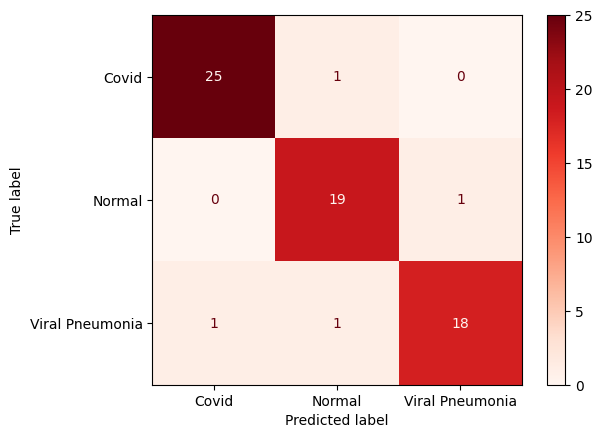

In [60]:
# Visualize the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_dataset.classes)
conf_matrix_display.plot(cmap=pslt.cm.Reds)
plt.show()
